In [1]:
#import relevant libraries 
import pandas as pd
import plotly.express as px
import panel as pn
import hvplot.pandas
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta,date
from pandas import DataFrame


Pull in External Functions and Classes

In [2]:
from ticker_data import *
from coin_data import *
from EMA import *
from BOLLINGER import *
from MACD import *
from LSTM import *

Get the Stock Ticker Data

In [3]:
#set the stock of interest
ticker='SPY'
#from ticker_data.py run function get_ticker_data
stock_data_df=get_ticker_data(api,ticker)

Get the Crypto Coin Data

In [4]:
#set the crypto of interest
ticker='BTC/USD'
#from ticker_data.py run function get_ticker_data
crypto_data_df=get_crypto_data(exchange,ticker)
crypto_data_df.columns=["Timestamp", "Open", "High", "Low", "Close", "Volume"]


In [5]:
crypto_data_df.head()

Timestamp    Open    High     Low   Close       Volume
Date                                                                  
2018-09-03  1535932800000  7294.5  7329.9  7183.5  7256.1  2119.023043
2018-09-04  1536019200000  7256.1  7405.9  7219.2  7359.3  2791.506356
2018-09-05  1536105600000  7359.3  7389.4  6638.8  6686.6  7620.246686
2018-09-06  1536192000000  6684.4  6702.3  6250.0  6494.8  9576.541423
2018-09-07  1536278400000  6494.8  6524.8  6318.8  6397.6  3234.923559

EMA Simulation and Optimal Calculations

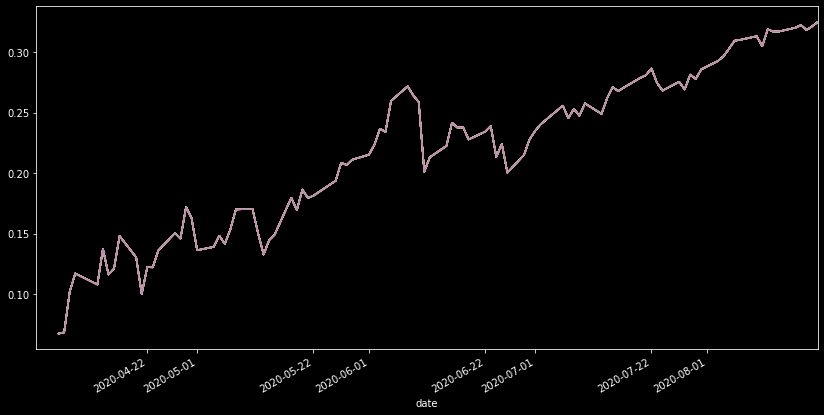

In [6]:
#from EMA.py run EMA_Optimal Calculator
ema_result=EMA_Optimal(stock_data_df)
opt_ema_df=ema_result.head()

In [7]:
#define the optimal outputs as variables
period=opt_ema_df['period'].iloc[0]
long_window=opt_ema_df['long_window'].iloc[0]
short_window=opt_ema_df['short_window'].iloc[0]

('12H', 32.0, 10.0, 0.3250941282632215, date
 2020-04-02    NaN
 2020-04-03    NaN
 2020-04-06    1.0
 2020-04-07    1.0
 2020-04-08    1.0
              ... 
 2020-08-17    1.0
 2020-08-18    1.0
 2020-08-19    1.0
 2020-08-20    1.0
 2020-08-21    1.0
 Name: EMA Signal, Length: 99, dtype: float64)

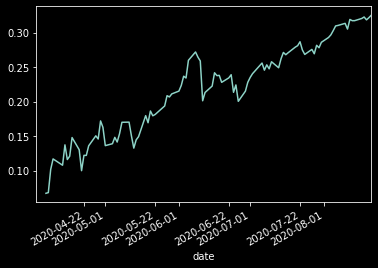

In [8]:
#from EMA.py run the EMA simulator on the optimal variables
EMAsimulator = EMASimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    long_window=long_window, 
    short_window=short_window
)
EMAsimulator.simulate()

Bollinger Band Simulation and Optimal Calculations

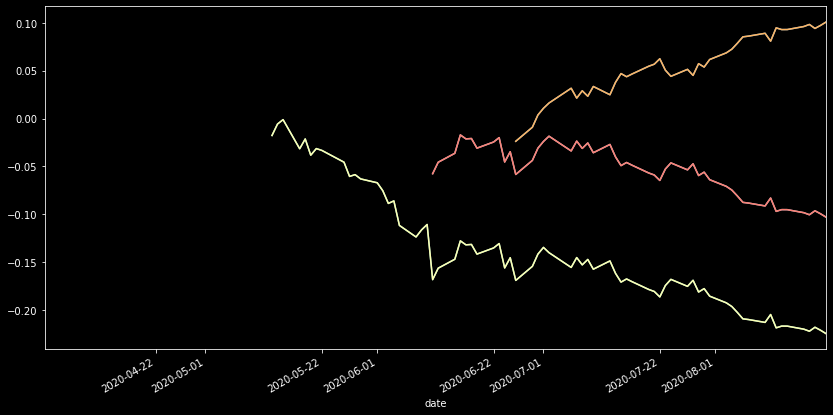

In [9]:
#from BOLLINGER.py run Bollinger_Band_Optimal Calculator
bollinger_result=Bollinger_Band_Optimal(stock_data_df)
opt_bollinger_df=bollinger_result.head()

In [10]:
#define the optimal outputs as variables
period=opt_bollinger_df['period'].iloc[0]
bollinger_window=int(opt_bollinger_df['bollinger_window'].iloc[0])
no_of_std=opt_bollinger_df['no_of_std'].iloc[0]

('12H', 10, 2.0, 0.10092310359224355, date
 2020-04-02    NaN
 2020-04-03    NaN
 2020-04-06    NaN
 2020-04-07    NaN
 2020-04-08    NaN
              ... 
 2020-08-17    1.0
 2020-08-18    1.0
 2020-08-19    1.0
 2020-08-20    1.0
 2020-08-21    1.0
 Name: Bollinger Signal, Length: 99, dtype: float64)

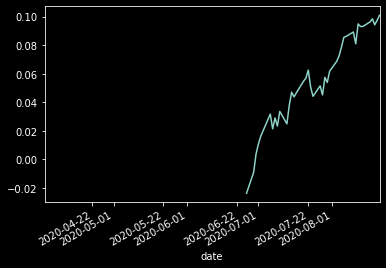

In [11]:
#from BOLLINGER.py run the BOLLINGER simulator on the optimal variables
BOLLINGERsimulator = BollingerBandsSimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    bollinger_window=bollinger_window, 
    no_of_std=no_of_std
)
BOLLINGERsimulator.simulate()

MACD Simulation and Optimal Calculations

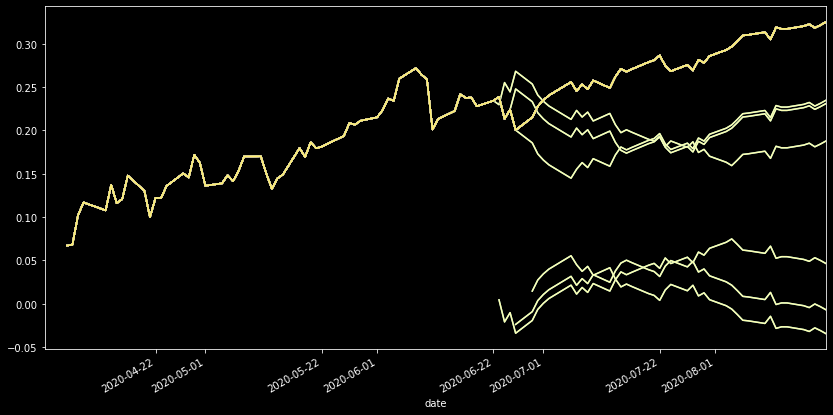

In [12]:
#from MACD.py run MACD_Optimal Calculator
macd_result=MACD_Optimal(stock_data_df)
opt_macd_df=macd_result.head()

In [13]:
#define the optimal outputs as variables
period=opt_macd_df['period'].iloc[0]
span1=opt_macd_df['span1'].iloc[0]
span2=opt_macd_df['span2'].iloc[0]
span3=opt_macd_df['span3'].iloc[0]

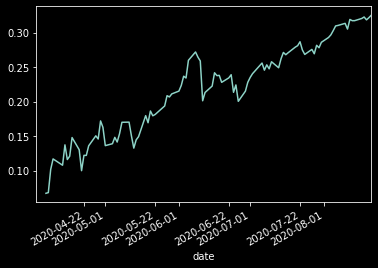

In [14]:
#from MACD.py run the MACD simulator on the optimal variables
MACDsimulator = MACDSimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    span1=span1,
    span2=span2,
    span3=span3
)
MACDSignals=MACDsimulator.simulate()

Look at the Resulting Signal Data and Stock Data

In [15]:
stock_data_df.dropna(subset=('EMA Signal','Bollinger Signal', 'MACD Signal'),inplace=True)

In [16]:
ema_signal_df=stock_data_df['EMA Signal']
bollinger_signal_df=stock_data_df['Bollinger Signal']
macd_signal_df=stock_data_df['MACD Signal']
close_df=stock_data_df['Close']

Get All Signals and Combined Signal

In [17]:
#function to get all trading signals
#return data frame holding trading signals
def get_trading_signals(close_df,ema_signal_df,bollinger_signal_df,macd_signal_df):
    trading_signal_df=pd.concat([close_df,ema_signal_df, bollinger_signal_df,macd_signal_df],axis=1,    join="inner")
    trading_signal_df['Signal']=trading_signal_df['EMA Signal']+ trading_signal_df['Bollinger Signal']+ trading_signal_df['MACD Signal']
    #trading_signal_df['Overall Entry/Exit']=trading_signal_df['Signal'].diff()
    return trading_signal_df
    

In [18]:
trading_signal_df=get_trading_signals(close_df,ema_signal_df,bollinger_signal_df,macd_signal_df)
trading_signal_df.head()

Close  EMA Signal  Bollinger Signal  MACD Signal  Signal
date                                                                 
2020-06-26  300.05         1.0               1.0          1.0     3.0
2020-06-29  304.46         1.0               1.0          1.0     3.0
2020-06-30  308.36         1.0               1.0          1.0     3.0
2020-07-01  310.52         1.0               1.0          1.0     3.0
2020-07-02  312.23         1.0               1.0          1.0     3.0

In [19]:
stocks=predict_price_model(trading_signal_df)

X_train sample values:
[[[0.]]] 

X_test sample values:
[[[0.77766261]]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 10)             480       
_________________________________________________________________
dropout (Dropout)            (None, 1, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________

In [45]:
signal_support_df=stocks[0]
signal_support_df

Real   Predicted  Difference  Support
0   332.11  321.938934   10.171066        1
1   334.33  322.424805   11.905195        1
2   334.57  322.959320   11.610680        1
3   335.57  323.017609   12.552391        1
4   332.80  323.261292    9.538708        1
5   337.44  322.590088   14.849912        1
6   336.83  323.720703   13.109297        1
7   336.84  323.570312   13.269687        1
8   337.91  323.572815   14.337185        1
9   338.64  323.836914   14.803086        1
10  337.23  324.017853   13.212147        1
11  338.28  323.668884   14.611116        1

In [24]:
signal_support_value=signal_support_df['Support'].mean()

In [26]:
stocks[1]

:NdOverlay   [Variable]
   :Curve   [index]   (Price (USD))

Check Signals and Call Functions to Place Trades

In [ ]:
if trading_signal_df['Signal']>=1 and signal_support_value>=1:
    #place a buy order
    side='buy'
    order_type='market'
    time_in_force='gtc'
    qty=1
    ###place_market_order(ticker,qty, side, order_type, time_in_force)
elif trading_signal_df['Signal']<=-1 and signal_support_value>=1:
    #place a sell order
    side='sell'
    order_type='market'
    time_in_force='gtc'
    qty=1
    ####place_market_order(ticker,qty, side, order_type, time_in_force)

Apply for Crypto Data Signals and Simulators

EMA Simulator and Optimal Calculation Crypto

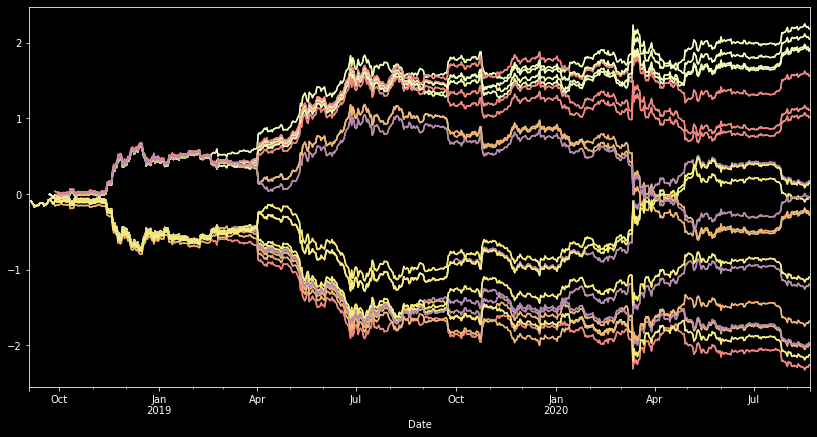

In [27]:
#from EMA.py run EMA_Optimal Calculator
ema_result=EMA_Optimal(crypto_data_df)
opt_ema_df=ema_result.head()

In [28]:
#define the optimal outputs as variables
period=opt_ema_df['period'].iloc[0]
long_window=opt_ema_df['long_window'].iloc[0]
short_window=opt_ema_df['short_window'].iloc[0]

('12H', 32.0, 10.0, 2.1862585801868866, Date
 2018-09-03    NaN
 2018-09-04    NaN
 2018-09-05    NaN
 2018-09-06    NaN
 2018-09-07    NaN
              ... 
 2020-08-18    1.0
 2020-08-19    1.0
 2020-08-20    1.0
 2020-08-21    1.0
 2020-08-22    1.0
 Name: EMA Signal, Length: 720, dtype: float64)

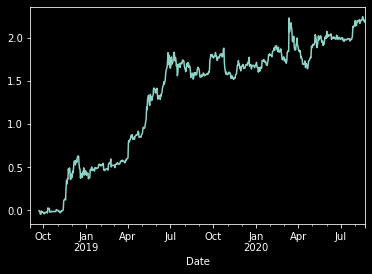

In [29]:
#from EMA.py run the EMA simulator on the optimal variables
EMAsimulator = EMASimulator(
    crypto_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    long_window=long_window, 
    short_window=short_window
)
EMAsimulator.simulate()

Bollinger Bands Simulator and Optimal Calculation Crypto

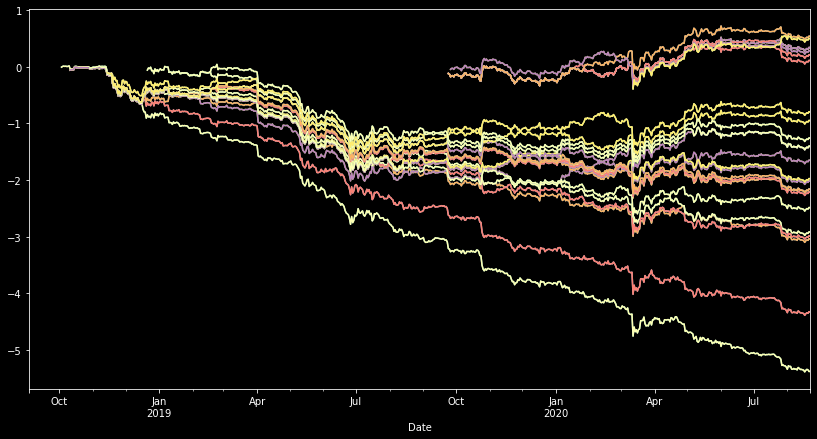

In [30]:
#from BOLLINGER.py run Bollinger_Band_Optimal Calculator
bollinger_result=Bollinger_Band_Optimal(crypto_data_df)
opt_bollinger_df=bollinger_result.head()

In [31]:
#define the optimal outputs as variables
period=opt_bollinger_df['period'].iloc[0]
bollinger_window=int(opt_bollinger_df['bollinger_window'].iloc[0])
no_of_std=opt_bollinger_df['no_of_std'].iloc[0]

('48H', 100, 2.0, 0.5387178578528322, Date
 2018-09-03    NaN
 2018-09-04    NaN
 2018-09-05    NaN
 2018-09-06    NaN
 2018-09-07    NaN
              ... 
 2020-08-18   -1.0
 2020-08-19   -1.0
 2020-08-20   -1.0
 2020-08-21   -1.0
 2020-08-22   -1.0
 Name: Bollinger Signal, Length: 720, dtype: float64)

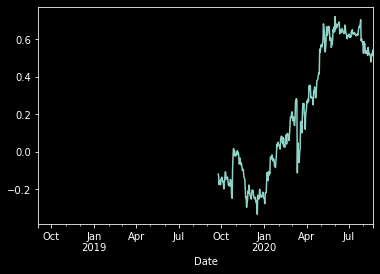

In [32]:
#from BOLLINGER.py run the BOLLINGER simulator on the optimal variables
BOLLINGERsimulator = BollingerBandsSimulator(
    crypto_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    bollinger_window=bollinger_window, 
    no_of_std=no_of_std
)
BOLLINGERsimulator.simulate()

MACD Simulator and Optimal Calculation Crypto

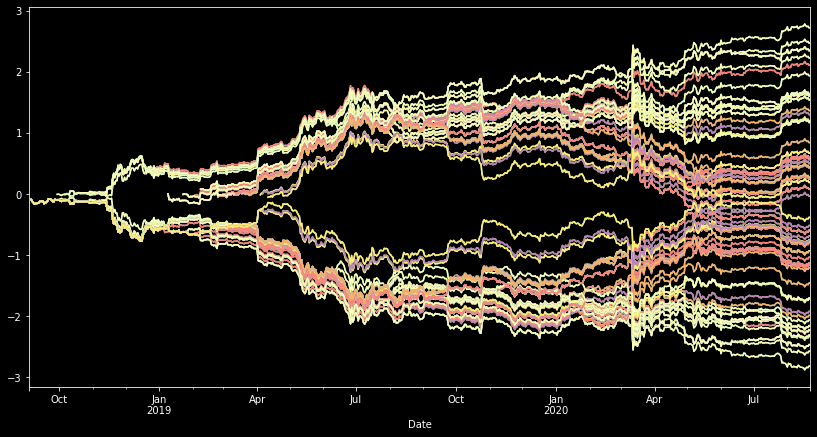

In [33]:
#from MACD.py run MACD_Optimal Calculator
macd_result=MACD_Optimal(crypto_data_df)
opt_macd_df=macd_result.head()

In [34]:
#define the optimal outputs as variables
period=opt_macd_df['period'].iloc[0]
span1=opt_macd_df['span1'].iloc[0]
span2=opt_macd_df['span2'].iloc[0]
span3=opt_macd_df['span3'].iloc[0]

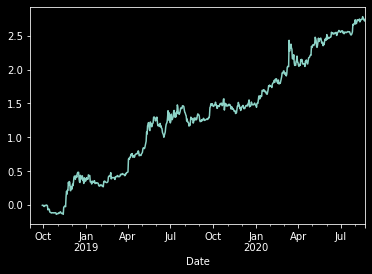

In [35]:
#from MACD.py run the MACD simulator on the optimal variables
MACDsimulator = MACDSimulator(
    crypto_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    span1=span1,
    span2=span2,
    span3=span3
)
MACDSignals=MACDsimulator.simulate()

In [36]:
crypto_data_df.dropna(subset=('EMA Signal','Bollinger Signal', 'MACD Signal'),inplace=True)
crypto_data_df.head()

Timestamp    Open    High     Low   Close        Volume  \
Date                                                                      
2019-09-24  1569283200000  9686.9  9776.0  8046.0  8536.7  15008.200906   
2019-09-25  1569369600000  8536.7  8740.2  8000.0  8439.0   9379.764257   
2019-09-26  1569456000000  8439.0  8465.7  7730.0  8060.3   9916.644784   
2019-09-27  1569542400000  8063.0  8290.0  7850.0  8196.0   6928.867827   
2019-09-28  1569628800000  8196.0  8426.0  8024.9  8213.5   3578.308591   

              EWM Short      EWM Long  EMA Signal  EMA Daily Return  ...  \
Date                                                                 ...   
2019-09-24  9799.184887  10128.133071        -1.0         -0.118738  ...   
2019-09-25  9551.878544  10025.761370        -1.0         -0.011445  ...   
2019-09-26  9280.682445   9906.642499        -1.0         -0.044875  ...   
2019-09-27  9083.467455   9802.967196        -1.0          0.016836  ...   
2019-09-28  8925.291554   9706.635851        -1.0          0.002135  ...   

            Bollinger Signal  Bollinger Daily Return  \
Date                                                   
2019-09-24               1.0               -0.118738   
2019-09-25               1.0               -0.011445   
2019-09-26               1.0               -0.044875   
2019-09-27               1.0                0.016836   
2019-09-28               1.0                0.002135   

            Bollinger Strategy Return          exp1          exp2        macd  \
Date                                                                            
2019-09-24                  -0.118738  10026.180891  10156.859833 -130.678942   
2019-09-25                  -0.011445   9881.891719  10104.803474 -222.911755   
2019-09-26                  -0.044875   9716.292472  10042.848823 -326.556351   
2019-09-27                   0.016836   9578.084065   9986.883708 -408.799642   
2019-09-28                   0.002135   9454.030969   9933.144807 -479.113839   

              macdout  MACD Signal  MACD Daily Return  MACD Strategy Return  
Date                                                                         
2019-09-24  54.200472         -1.0          -0.118738              0.118738  
2019-09-25  29.008452         -1.0          -0.011445              0.011445  
2019-09-26  -3.315621         -1.0          -0.044875              0.044875  
2019-09-27 -40.177805         -1.0           0.016836             -0.016836  
2019-09-28 -80.081081         -1.0           0.002135             -0.002135  

[5 rows x 25 columns]

In [37]:
ema_signal_df=crypto_data_df['EMA Signal']
bollinger_signal_df=crypto_data_df['Bollinger Signal']
macd_signal_df=crypto_data_df['MACD Signal']
close_df=crypto_data_df['Close']

In [38]:
trading_signal_df=get_trading_signals(close_df,ema_signal_df,bollinger_signal_df,macd_signal_df)
trading_signal_df.head()

Close  EMA Signal  Bollinger Signal  MACD Signal  Signal
Date                                                                 
2019-09-24  8536.7        -1.0               1.0         -1.0    -1.0
2019-09-25  8439.0        -1.0               1.0         -1.0    -1.0
2019-09-26  8060.3        -1.0               1.0         -1.0    -1.0
2019-09-27  8196.0        -1.0               1.0         -1.0    -1.0
2019-09-28  8213.5        -1.0               1.0         -1.0    -1.0

In [39]:
crypto=predict_price_model(trading_signal_df)

X_train sample values:
[[[0.49474617]]] 

X_test sample values:
[[[0.59947395]]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 10)             480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_______________________________________

In [44]:
signal_support_df=stocks[0]
signal_support_df.tail(50)

Real   Predicted  Difference  Support
0   332.11  321.938934   10.171066        1
1   334.33  322.424805   11.905195        1
2   334.57  322.959320   11.610680        1
3   335.57  323.017609   12.552391        1
4   332.80  323.261292    9.538708        1
5   337.44  322.590088   14.849912        1
6   336.83  323.720703   13.109297        1
7   336.84  323.570312   13.269687        1
8   337.91  323.572815   14.337185        1
9   338.64  323.836914   14.803086        1
10  337.23  324.017853   13.212147        1
11  338.28  323.668884   14.611116        1

In [42]:
signal_support_value=signal_support_df['Support'].mean()
signal_support_value

1.0

In [ ]:
if trading_signal_df['Signal']>=1 and signal_support_value>=1:
    #place a buy order on kraken
    
    ###FUNCTION HERE
elif trading_signal_df['Signal']<=-1 and signal_support_value>=1:
    #place a sell order on kraken
    
    ####FUNCTION